In [0]:
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'horse','ship', 'truck'}

background_classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog'}

# print(type(foreground_classes))

In [0]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    

In [0]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

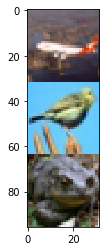

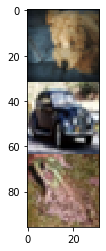

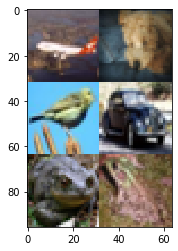

torch.Size([3, 96, 32])


In [0]:
img1 = torch.cat((background_data[0],background_data[1],background_data[2]),1)
imshow(img1)
img2 = torch.cat((background_data[27],background_data[3],background_data[43]),1)
imshow(img2)
img3 = torch.cat((img1,img2),2)
imshow(img3)
print(img2.size())


In [0]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]-7  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [0]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)



8


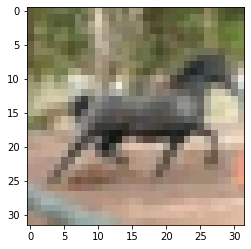

horse


In [0]:
qw=45

print(fore_idx[qw])
imshow(mosaic_list_of_images[qw][fore_idx[qw]])
# print(mosaic_list_of_images[0])
print(classes[mosaic_label[qw]+7]) # add 7 as we had subtracted 7 while saving

# imshow(mosaic_list_of_images[13][2])
# print(type(mosaic_list_of_images[1][0]))
# print(mosaic_label)

In [0]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Module1(nn.Module):
  def __init__(self):
    super(Module1, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,1)

  def forward(self, z):
    x = torch.zeros([batch,9],dtype=torch.float64)
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x,y = x.to("cuda"),y.to("cuda")
    for i in range(9):
      x[:,i] = self.helper(z[:,i])[:,0]
    x = F.softmax(x,dim=1)   # alphas
    
    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])
    return y , x 
  
  def helper(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x
      


In [0]:
 class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self,y):  #z batch of list of 9 images
    y1 = self.pool(F.relu(self.conv1(y)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    y1 = y1.view(-1, 16 * 5 * 5)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1 


In [0]:
where_net = Module1().double()
where_net = where_net.to("cuda")
# print(net.parameters)

In [0]:
# idx = np.random.randint(0,250,10)
# train_iter = iter(train_loader)
# images,labels,_=train_iter.next()

# for i in idx:
#   imshow(where_net1(images)[i].detach().numpy())

In [0]:
what_net = Module2().double()
what_net = what_net.to("cuda")

In [0]:
# where_net.load_state_dict(torch.load("model_epoch90.pt"))
# what_net.load_state_dict(torch.load("model_epoch90.pt"))
# print(fore_net.parameters)

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)

In [0]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [60]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer_where = optim.SGD(where_net.parameters(), lr=0.01, momentum=0.9)
optimizer_what = optim.SGD(what_net.parameters(), lr=0.001, momentum=0.9)

nos_epochs = 600
every_what_epoch = 50
#---------------------------------------------
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0
argmax_more_than_half = 0
argmax_less_than_half =0
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]
#-----------------------------------------------
train_loss=[]
test_loss =[]
train_acc = []
test_acc = []
for epoch in range(nos_epochs):  # loop over the dataset multiple times
    
  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  batch_correct = 0.0
  cnt=0
  total=0
  iteration = desired_num // batch



  #training data set

  if (epoch % (every_what_epoch*2) ) < every_what_epoch :
      print(epoch,"updating what_net, where_net is freezed")
  elif (epoch % (every_what_epoch*2)) > every_what_epoch :
      print(epoch,"updating where_net, what_net is freezed")
    
  for i, data in  enumerate(train_loader):
      inputs , labels , fore_idx = data
      inputs,labels = inputs.to("cuda"),labels.to("cuda") 
      # zero the parameter gradients
      
      optimizer_what.zero_grad()
      optimizer_where.zero_grad()
      
      avg_images , alphas = where_net(inputs)
      outputs = what_net(avg_images)
      
      _, predicted = torch.max(outputs.data, 1)
      

      loss = criterion(outputs, labels) 
      loss.backward() 
  
      if (epoch % (every_what_epoch*2) ) < every_what_epoch :
          optimizer_what.step()
      elif (epoch % (every_what_epoch*2)) > every_what_epoch :
          optimizer_where.step()
      batch_correct += sum(predicted == labels)
      total += len(predicted)
      running_loss += loss.item()
      if cnt % 120 == 119:    # print every 40 mini-batches
          print("--"*40)
          print("Epoch: ",epoch)
#             print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / 120))
          train_loss.append(running_loss/120)
          train_acc.append(batch_correct.item()/desired_num)
          print("total_Correct:",batch_correct.item(),"Total:",total,"train_loss",running_loss/120,"train_acc: ", batch_correct.item()/total)
          #running_loss = 0.0
      cnt=cnt+1

      if epoch % 5 == 0:
        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1

  if epoch % 5 == 0:
    col1.append(epoch)
    col2.append(argmax_more_than_half)
    col3.append(argmax_less_than_half)
    col4.append(focus_true_pred_true)
    col5.append(focus_false_pred_true)
    col6.append(focus_true_pred_false)
    col7.append(focus_false_pred_false)
  
    with torch.no_grad():
      loss = 0.0
      correct = 0.0
      tot =0
      focus_true_pred_true =0
      focus_false_pred_true =0
      focus_true_pred_false =0
      focus_false_pred_false =0
      argmax_more_than_half = 0
      argmax_less_than_half =0

      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs,labels = inputs.to("cuda"),labels.to("cuda") 
        avg_images , alphas = where_net(inputs)
        outputs = what_net(avg_images)
        _, predicted = torch.max(outputs.data, 1)
        loss += criterion(outputs, labels).item() 
        correct += sum(predicted == labels)
        tot += len(predicted)

        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1
          
      test_loss.append(loss/40) # 10000/250 = 40
      test_acc.append(correct.item()/tot)
      print("total_Correct:",correct.item(),"Total:",tot,"test loss: ", loss/40, "test accuracy", correct.item()/tot)

    col8.append(argmax_more_than_half)
    col9.append(argmax_less_than_half)
    col10.append(focus_true_pred_true)
    col11.append(focus_false_pred_true)
    col12.append(focus_true_pred_false)
    col13.append(focus_false_pred_false)

  elif epoch % 5 != 0  :
    with torch.no_grad():
      loss = 0.0
      correct = 0.0
      tot =0
      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs,labels = inputs.to("cuda"),labels.to("cuda") 
        avg_images , alphas = where_net(inputs)
        outputs = what_net(avg_images)
        _, predicted = torch.max(outputs.data, 1)
        loss += criterion(outputs, labels).item() 
        correct += sum(predicted == labels)
        tot += len(predicted)

      test_loss.append(loss/40) # 10000/250 = 40
      test_acc.append(correct.item()/tot)
      print("total_Correct:",correct.item(),"Total:",tot,"test loss: ", loss/40, "test accuracy", correct.item()/tot)
 
    
  if (epoch % (every_what_epoch*2) == every_what_epoch*2 - 1):
      torch.save(where_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/alternate_training_600epochs_every50epoch_what_lr_001_where_lr_01/where_model_at_epoch"+str(epoch)+".pt")
      torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/alternate_training_600epochs_every50epoch_what_lr_001_where_lr_01/what_model_at_epoch"+str(epoch)+".pt")
    
print('Finished Training')
torch.save(where_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/alternate_training_600epochs_every50epoch_what_lr_001_where_lr_01/full_where_model_epoch"+str(nos_epochs)+".pt")
torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/alternate_training_600epochs_every50epoch_what_lr_001_where_lr_01/full_what_model_epoch"+str(nos_epochs)+".pt")

0 updating what_net, where_net is freezed
--------------------------------------------------------------------------------
Epoch:  0
total_Correct: 10133.0 Total: 30000 train_loss 1.0991811076064493 train_acc:  0.33776666666666666
total_Correct: 3303.0 Total: 10000 test loss:  1.0995769530734556 test accuracy 0.3303
1 updating what_net, where_net is freezed
--------------------------------------------------------------------------------
Epoch:  1
total_Correct: 10133.0 Total: 30000 train_loss 1.0987938761306302 train_acc:  0.33776666666666666
total_Correct: 3303.0 Total: 10000 test loss:  1.099118785129467 test accuracy 0.3303
2 updating what_net, where_net is freezed
--------------------------------------------------------------------------------
Epoch:  2
total_Correct: 10133.0 Total: 30000 train_loss 1.0986339677309789 train_acc:  0.33776666666666666
total_Correct: 3303.0 Total: 10000 test loss:  1.0989537607030817 test accuracy 0.3303
3 updating what_net, where_net is freezed
-----

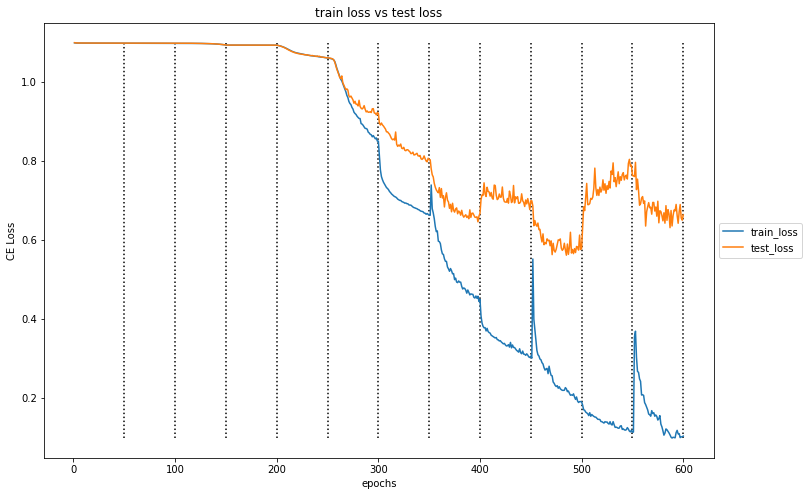

In [61]:
fig = plt.figure(figsize = (12,8) )
vline_list = np.arange(every_what_epoch, nos_epochs + every_what_epoch, every_what_epoch )
# train_loss = np.random.randn(340)
# test_loss = np.random.randn(340)
epoch_list = np.arange(1, nos_epochs+1)
plt.plot(epoch_list,train_loss, label='train_loss')
plt.plot(epoch_list,test_loss, label='test_loss')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("CE Loss")
plt.vlines(vline_list,min(min(train_loss),min(test_loss)), max(max(test_loss),max(train_loss)),linestyles='dotted')
plt.title("train loss vs test loss")
plt.show()
fig.savefig("train_test_loss_plot.pdf")


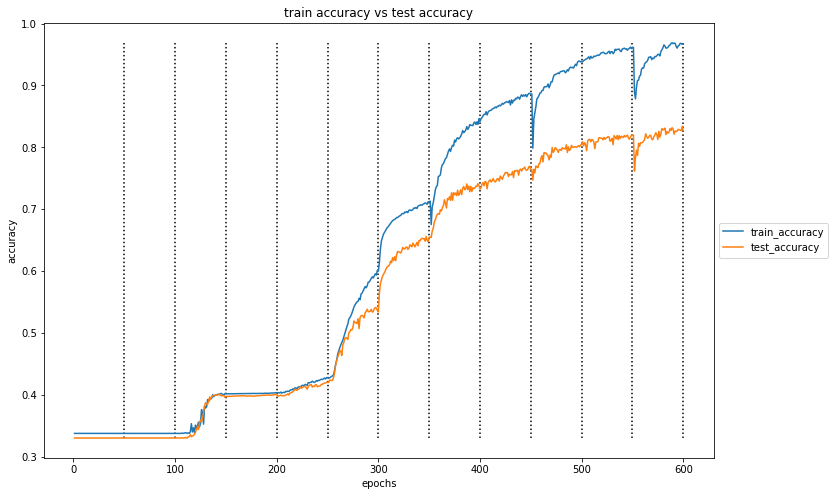

In [62]:
fig = plt.figure(figsize = (12,8) )
vline_list = np.arange(every_what_epoch, nos_epochs + every_what_epoch, every_what_epoch )
# train_acc = np.random.randn(340)
# test_acc = np.random.randn(340)
epoch_list = np.arange(1, nos_epochs+1)
plt.plot(epoch_list,train_acc, label='train_accuracy')
plt.plot(epoch_list,test_acc, label='test_accuracy')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.vlines(vline_list,min(min(train_acc),min(test_acc)), max(max(test_acc),max(train_acc)),linestyles='dotted')
plt.title("train accuracy vs test accuracy")
plt.show()
fig.savefig("train_test_acc_plot.pdf")

In [0]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [64]:
df_train

epochs  argmax > 0.5  ...  focus_true_pred_false  focus_false_pred_false
0         0             0  ...                   2018                   17849
1         5             0  ...                   2018                   17849
2        10             0  ...                   2018                   17849
3        15             0  ...                   2018                   17849
4        20             0  ...                   2018                   17849
..      ...           ...  ...                    ...                     ...
115     575         28621  ...                    379                    1114
116     580         28950  ...                    260                     774
117     585         28870  ...                    286                     782
118     590         29065  ...                    248                     701
119     595         28987  ...                    277                     775

[120 rows x 7 columns]

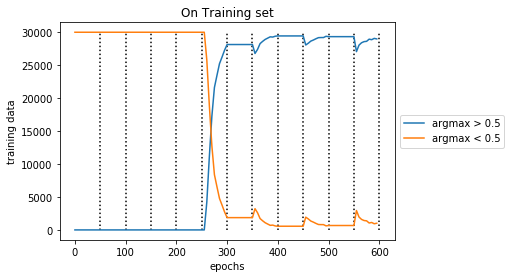

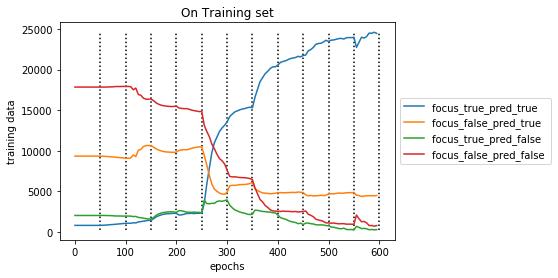

In [65]:
# plt.figure(12,12)
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.vlines(vline_list,min(min(col2),min(col3)), max(max(col2),max(col3)),linestyles='dotted')
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.vlines(vline_list,min(min(col4),min(col5),min(col6),min(col7)), max(max(col4),max(col5),max(col6),max(col7)),linestyles='dotted')
plt.show()

In [66]:
df_test

epochs  argmax > 0.5  ...  focus_true_pred_false  focus_false_pred_false
0         0             0  ...                    658                    6039
1         5             0  ...                    658                    6039
2        10             0  ...                    658                    6039
3        15             0  ...                    658                    6039
4        20             0  ...                    658                    6039
..      ...           ...  ...                    ...                     ...
115     575          9211  ...                    364                    1377
116     580          9420  ...                    357                    1353
117     585          9335  ...                    368                    1388
118     590          9334  ...                    351                    1437
119     595          9299  ...                    374                    1343

[120 rows x 7 columns]

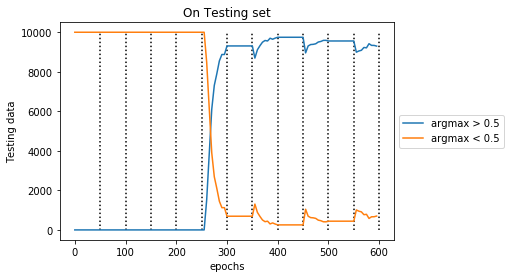

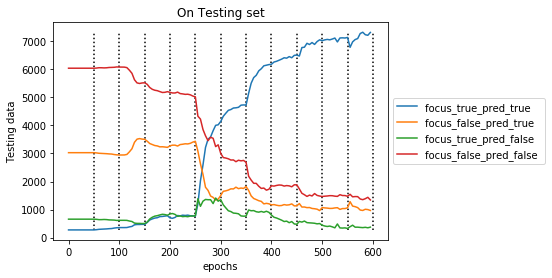

In [67]:
# plt.figure(12,12)
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.vlines(vline_list,min(min(col8),min(col9)), max(max(col8),max(col9)),linestyles='dotted')
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.vlines(vline_list,min(min(col10),min(col11),min(col12),min(col13)), max(max(col10),max(col11),max(col12),max(col13)),linestyles='dotted')
plt.show()

In [68]:
print("-"*20,"Training Dataset","-"*20)
print("epochs", col1) 
print("argmax > 0.5 ", col2) 
print("argmax < 0.5 ", col3) 
print("focus_true_pred_true", col4) 
print("focus_false_pred_true", col5)
print("focus_true_pred_false", col6) 
print("focus_false_pred_false", col7) 
print("-"*20,"Testing Dataset","-"*20)
print("argmax > 0.5 ", col8)
print("argmax < 0.5", col9) 
print("focus_true_pred_true", col10) 
print("focus_false_pred_true", col11)
print("focus_true_pred_false", col12) 
print("focus_false_pred_false", col13) 

-------------------- Training Dataset --------------------
epochs [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595]
argmax > 0.5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4220, 11116, 17263, 21610, 23448, 25230, 26229, 27270, 28136, 28136, 28136, 28136, 28136, 28136, 28136, 28136, 28136, 28136, 28136, 26777, 27393, 28275, 28612, 28908, 29108, 29303, 292

In [0]:
df_train.to_csv("/content/drive/My Drive/Research/stage_wise_training/alternate_training_600epochs_every50epoch_what_lr_001_where_lr_01/focus_vs_predicted_train.csv")
df_test.to_csv("/content/drive/My Drive/Research/stage_wise_training/alternate_training_600epochs_every50epoch_what_lr_001_where_lr_01/focus_vs_predicted_test.csv")

In [0]:
def display(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

****************************************************************************************************


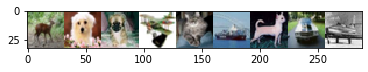

tensor([3.0894e-06, 3.1641e-12, 9.3130e-12, 1.0439e-13, 5.6564e-07, 9.9999e-01,
        3.6245e-10, 1.3719e-08, 6.3538e-06], device='cuda:0',
       dtype=torch.float64)


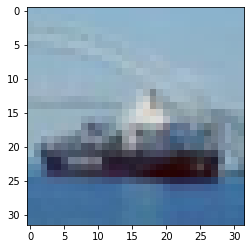

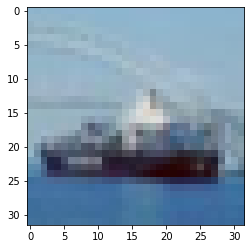

predicted ship
true ship
****************************************************************************************************


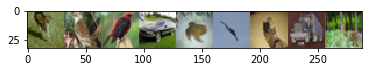

tensor([3.0540e-05, 5.6449e-02, 2.1360e-06, 9.2922e-01, 6.6186e-04, 2.1422e-08,
        3.5497e-04, 1.3281e-02, 5.4226e-07], device='cuda:0',
       dtype=torch.float64)


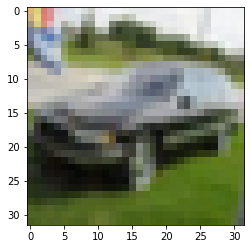

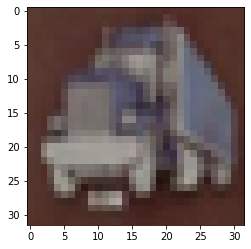

predicted truck
true truck
****************************************************************************************************


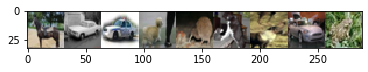

tensor([9.9694e-01, 7.4443e-04, 4.6170e-05, 7.2409e-05, 3.4137e-07, 5.2292e-09,
        9.0906e-06, 2.1042e-03, 8.4397e-05], device='cuda:0',
       dtype=torch.float64)


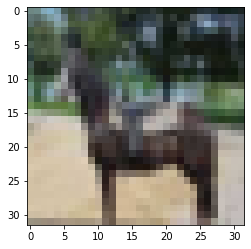

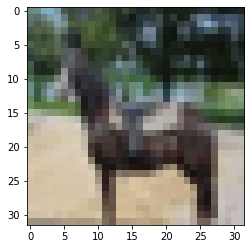

predicted horse
true horse
****************************************************************************************************


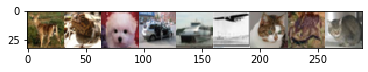

tensor([5.0634e-06, 1.0055e-06, 4.6652e-04, 4.3526e-03, 9.7653e-01, 1.0474e-03,
        8.9181e-07, 1.9701e-05, 1.7577e-02], device='cuda:0',
       dtype=torch.float64)


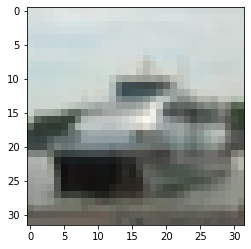

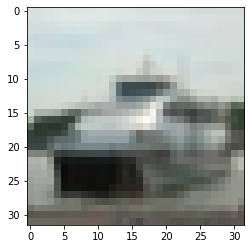

predicted ship
true ship
****************************************************************************************************


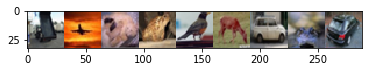

tensor([8.3079e-01, 2.3163e-13, 2.2559e-02, 5.4238e-03, 5.6728e-04, 2.0326e-04,
        3.8447e-03, 9.9077e-03, 1.2670e-01], device='cuda:0',
       dtype=torch.float64)


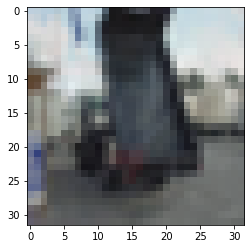

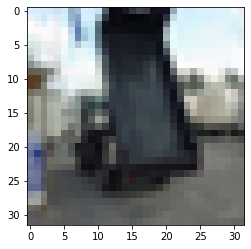

predicted truck
true truck
****************************************************************************************************


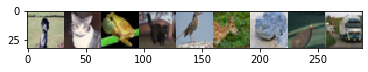

tensor([7.8621e-09, 4.2170e-10, 6.8864e-08, 3.3976e-03, 3.4904e-06, 4.4530e-05,
        1.1852e-04, 5.6896e-05, 9.9638e-01], device='cuda:0',
       dtype=torch.float64)


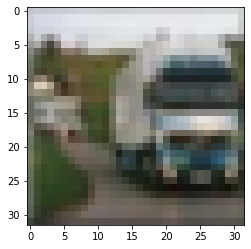

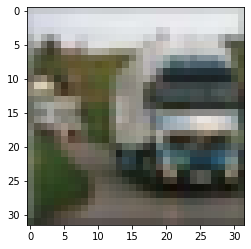

predicted truck
true truck
****************************************************************************************************


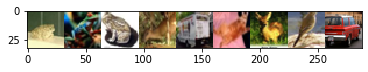

tensor([1.7082e-05, 1.2436e-09, 1.0959e-04, 5.7615e-04, 9.9896e-01, 1.7720e-06,
        2.7089e-06, 1.3305e-05, 3.1957e-04], device='cuda:0',
       dtype=torch.float64)


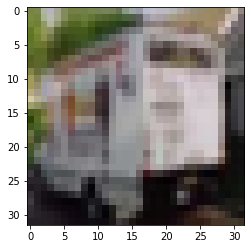

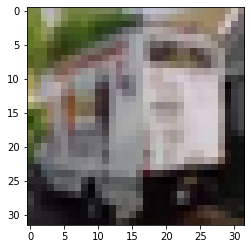

predicted truck
true truck
****************************************************************************************************


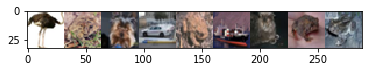

tensor([2.1444e-06, 1.5793e-03, 1.3060e-05, 1.5761e-02, 1.4719e-02, 4.0070e-01,
        3.5109e-03, 8.4013e-04, 5.6287e-01], device='cuda:0',
       dtype=torch.float64)


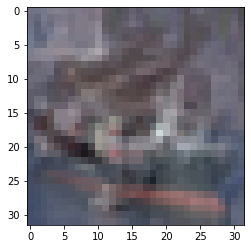

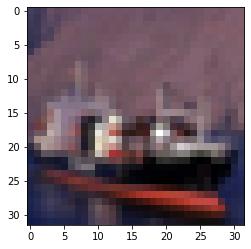

predicted truck
true ship
****************************************************************************************************


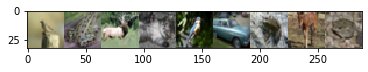

tensor([2.8395e-06, 1.6533e-02, 4.5883e-02, 1.0217e-02, 8.2659e-01, 2.5028e-03,
        7.1962e-02, 3.2751e-05, 2.6278e-02], device='cuda:0',
       dtype=torch.float64)


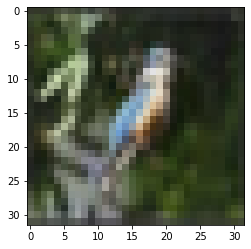

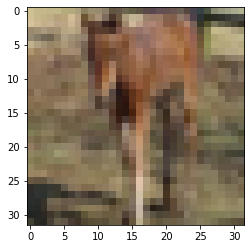

predicted horse
true horse
****************************************************************************************************


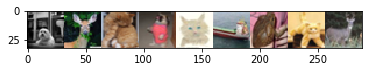

tensor([3.1043e-03, 3.0392e-03, 1.9279e-04, 3.2651e-08, 9.2737e-06, 9.8528e-01,
        7.9628e-03, 4.0708e-04, 1.2373e-06], device='cuda:0',
       dtype=torch.float64)


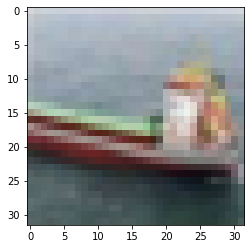

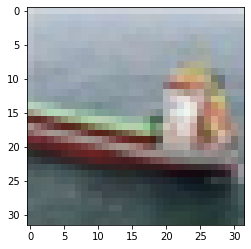

predicted ship
true ship
****************************************************************************************************


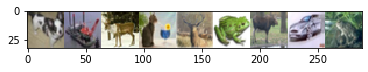

tensor([0.0013, 0.0340, 0.0102, 0.1155, 0.0060, 0.1139, 0.1944, 0.2785, 0.2461],
       device='cuda:0', dtype=torch.float64)


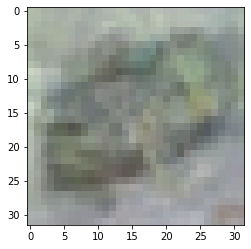

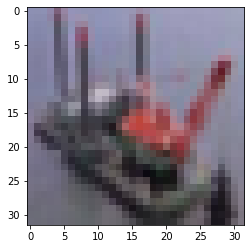

predicted ship
true ship
****************************************************************************************************


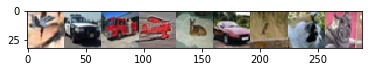

tensor([7.0768e-02, 1.7699e-03, 2.6728e-01, 1.2533e-01, 3.8916e-05, 5.2696e-01,
        6.9755e-03, 7.8132e-06, 8.7832e-04], device='cuda:0',
       dtype=torch.float64)


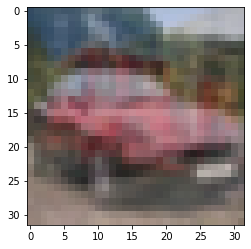

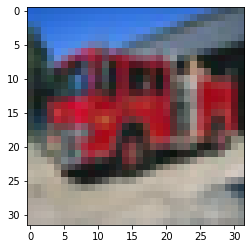

predicted truck
true truck
****************************************************************************************************


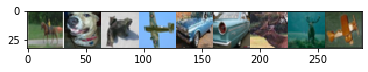

tensor([9.9051e-01, 1.1937e-07, 1.9839e-03, 2.0830e-07, 7.4339e-03, 4.7578e-05,
        2.9356e-07, 1.9454e-05, 3.1356e-09], device='cuda:0',
       dtype=torch.float64)


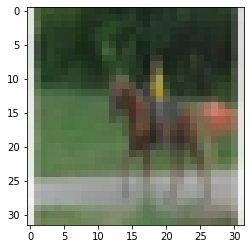

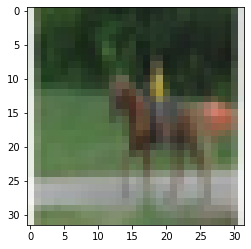

predicted horse
true horse
****************************************************************************************************


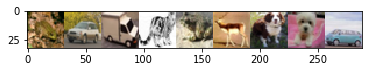

tensor([9.8281e-05, 1.8665e-06, 9.9716e-01, 1.8925e-07, 1.3805e-04, 5.4922e-04,
        3.3300e-05, 4.6101e-04, 1.5583e-03], device='cuda:0',
       dtype=torch.float64)


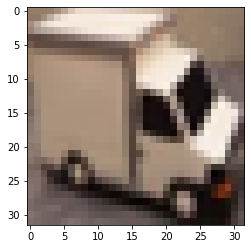

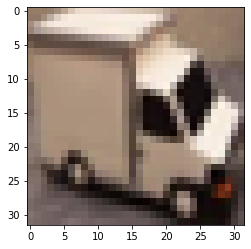

predicted truck
true truck
****************************************************************************************************


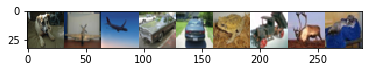

tensor([1.0976e-03, 1.4337e-01, 1.9506e-07, 4.7216e-05, 5.2051e-03, 1.1285e-05,
        1.1841e-03, 8.2855e-01, 2.0531e-02], device='cuda:0',
       dtype=torch.float64)


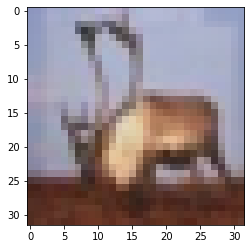

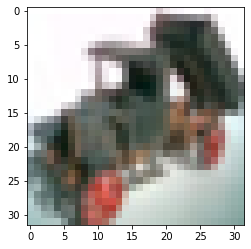

predicted truck
true truck
****************************************************************************************************


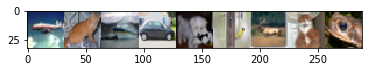

tensor([1.0764e-03, 1.6385e-04, 9.8264e-01, 2.4492e-03, 6.5541e-03, 8.0903e-05,
        5.0261e-05, 5.4983e-03, 1.4912e-03], device='cuda:0',
       dtype=torch.float64)


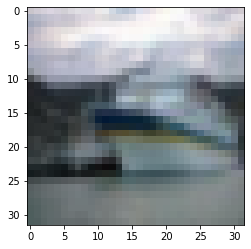

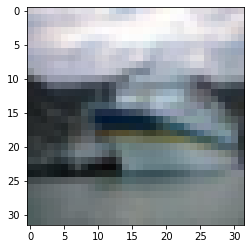

predicted ship
true ship
****************************************************************************************************


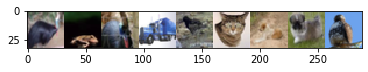

tensor([3.4753e-04, 5.0157e-04, 6.7032e-03, 7.4984e-01, 2.4067e-01, 1.2752e-03,
        2.5047e-05, 1.4141e-04, 4.9118e-04], device='cuda:0',
       dtype=torch.float64)


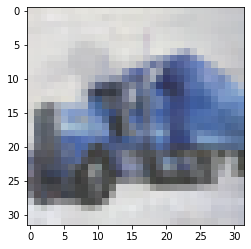

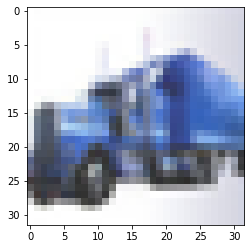

predicted truck
true truck
****************************************************************************************************


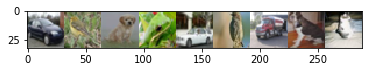

tensor([5.1671e-02, 1.1617e-06, 4.7657e-05, 5.5593e-13, 2.0595e-03, 3.5561e-03,
        9.4202e-01, 6.0535e-04, 4.3408e-05], device='cuda:0',
       dtype=torch.float64)


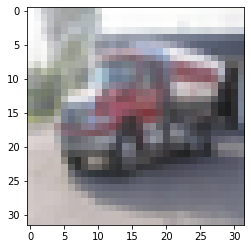

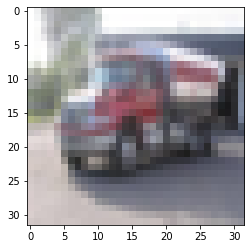

predicted truck
true truck
****************************************************************************************************


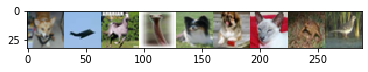

tensor([1.3868e-02, 9.8625e-06, 1.0289e-01, 9.0261e-05, 8.2755e-01, 5.4551e-08,
        4.0629e-02, 4.7839e-03, 1.0184e-02], device='cuda:0',
       dtype=torch.float64)


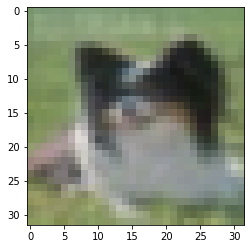

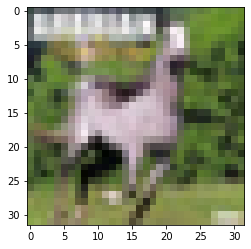

predicted horse
true horse
****************************************************************************************************


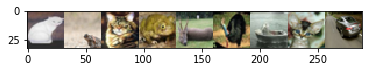

tensor([1.6409e-03, 3.2213e-05, 2.5221e-04, 2.6866e-02, 3.7742e-04, 7.9747e-07,
        9.6698e-01, 3.8470e-03, 2.1979e-06], device='cuda:0',
       dtype=torch.float64)


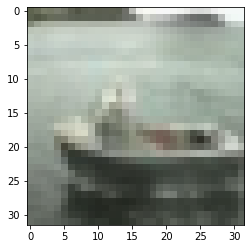

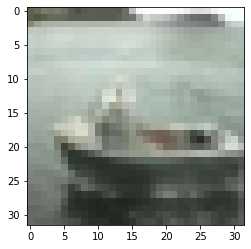

predicted ship
true ship
****************************************************************************************************


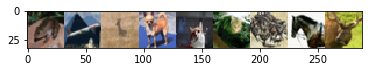

tensor([4.6844e-02, 5.3036e-06, 1.9272e-05, 3.5505e-04, 3.0320e-03, 1.4311e-04,
        3.0092e-02, 9.1951e-01, 8.7952e-08], device='cuda:0',
       dtype=torch.float64)


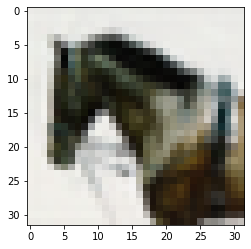

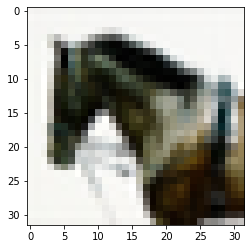

predicted horse
true horse
****************************************************************************************************


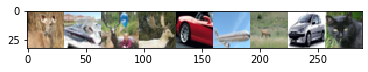

tensor([6.2814e-04, 3.2046e-01, 2.6497e-01, 2.5229e-02, 1.2906e-05, 1.0968e-01,
        1.5807e-02, 1.2813e-01, 1.3508e-01], device='cuda:0',
       dtype=torch.float64)


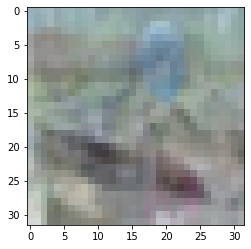

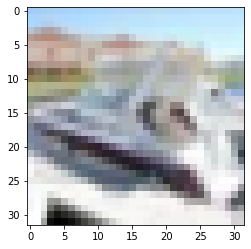

predicted ship
true ship
****************************************************************************************************


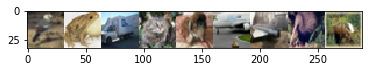

tensor([2.2074e-05, 1.3663e-06, 9.9980e-01, 2.7514e-05, 7.2908e-06, 4.3906e-05,
        7.3426e-05, 2.3678e-05, 7.4692e-08], device='cuda:0',
       dtype=torch.float64)


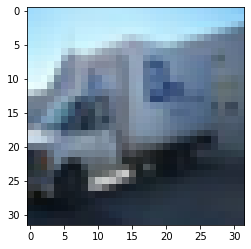

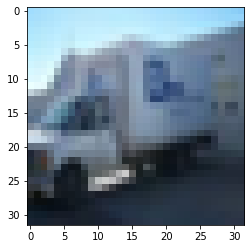

predicted truck
true truck
****************************************************************************************************


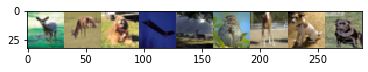

tensor([4.8979e-06, 1.3705e-02, 3.9595e-04, 7.2330e-04, 9.9925e-04, 2.9757e-06,
        9.8202e-01, 3.4075e-09, 2.1525e-03], device='cuda:0',
       dtype=torch.float64)


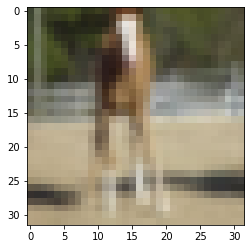

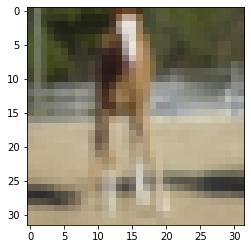

predicted horse
true horse
****************************************************************************************************


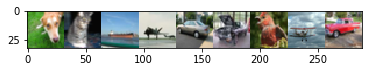

tensor([8.4059e-09, 8.0679e-09, 9.9954e-01, 3.0624e-04, 5.0083e-06, 8.8483e-05,
        5.2262e-05, 2.1134e-06, 3.4265e-06], device='cuda:0',
       dtype=torch.float64)


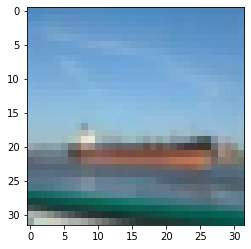

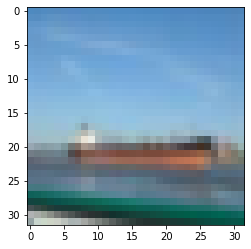

predicted ship
true ship
****************************************************************************************************


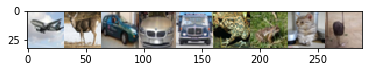

tensor([1.2537e-04, 7.0685e-05, 7.2223e-03, 7.1243e-03, 9.6277e-01, 8.2183e-04,
        2.0298e-05, 5.1948e-03, 1.6651e-02], device='cuda:0',
       dtype=torch.float64)


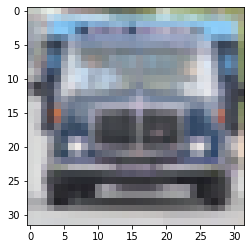

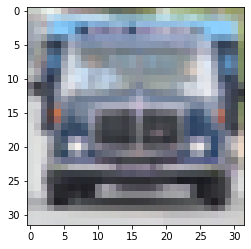

predicted truck
true truck
****************************************************************************************************


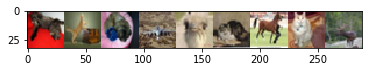

tensor([1.1157e-05, 9.6422e-08, 2.5461e-07, 7.4573e-06, 1.9447e-05, 1.0196e-05,
        9.9995e-01, 1.1594e-07, 1.2154e-09], device='cuda:0',
       dtype=torch.float64)


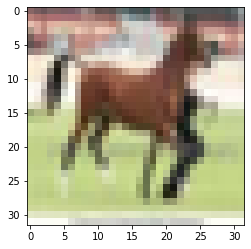

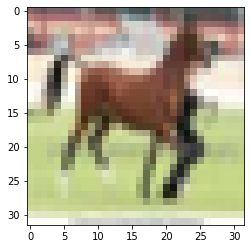

predicted horse
true horse
****************************************************************************************************


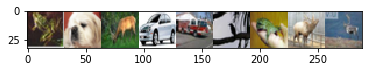

tensor([1.0193e-01, 8.6213e-05, 5.4484e-06, 6.6741e-05, 8.9081e-01, 2.4974e-04,
        2.2202e-08, 1.5104e-03, 5.3371e-03], device='cuda:0',
       dtype=torch.float64)


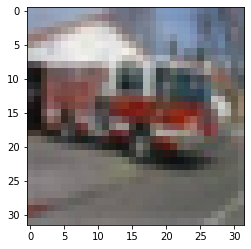

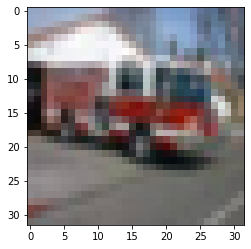

predicted truck
true truck
****************************************************************************************************


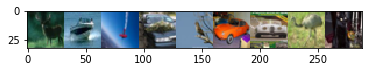

tensor([3.7997e-02, 9.3365e-01, 7.2296e-07, 1.7509e-04, 1.2465e-03, 1.4129e-02,
        1.2706e-02, 5.1446e-05, 4.0293e-05], device='cuda:0',
       dtype=torch.float64)


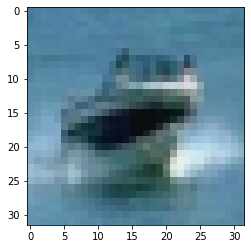

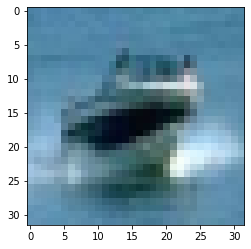

predicted ship
true ship
****************************************************************************************************


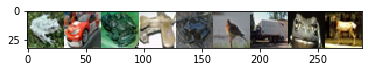

tensor([8.1808e-06, 1.3703e-02, 2.1171e-02, 4.0235e-08, 3.3949e-03, 3.4755e-05,
        9.6167e-01, 2.5973e-07, 1.6994e-05], device='cuda:0',
       dtype=torch.float64)


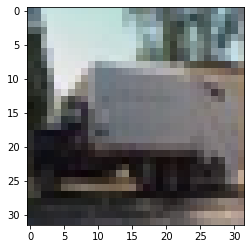

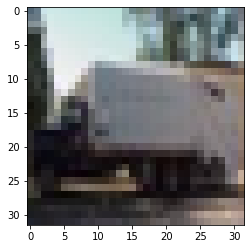

predicted truck
true truck
****************************************************************************************************


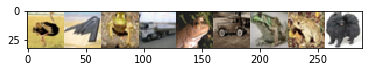

tensor([1.0766e-14, 2.8828e-06, 1.8646e-15, 9.9858e-01, 1.3455e-03, 2.4863e-06,
        5.4810e-05, 1.3385e-09, 1.2540e-05], device='cuda:0',
       dtype=torch.float64)


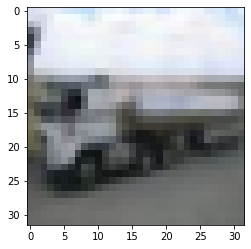

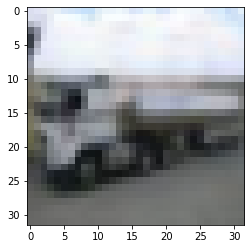

predicted truck
true truck
****************************************************************************************************


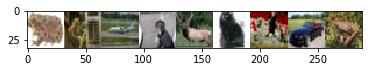

tensor([1.4706e-05, 2.3981e-02, 4.6692e-03, 1.6565e-02, 2.9659e-03, 4.8942e-03,
        9.4689e-01, 1.7972e-05, 1.2130e-07], device='cuda:0',
       dtype=torch.float64)


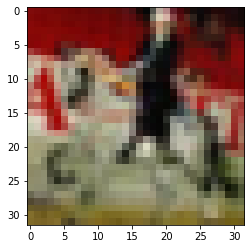

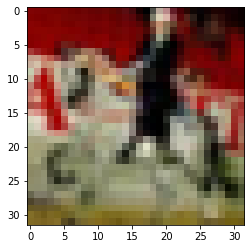

predicted horse
true horse
****************************************************************************************************


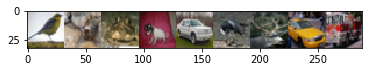

tensor([5.9254e-07, 1.8750e-02, 1.8688e-02, 6.1969e-02, 5.2653e-01, 1.4216e-04,
        1.7445e-02, 3.1847e-05, 3.5645e-01], device='cuda:0',
       dtype=torch.float64)


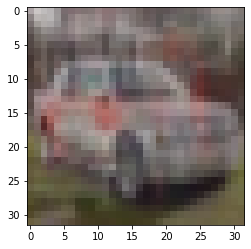

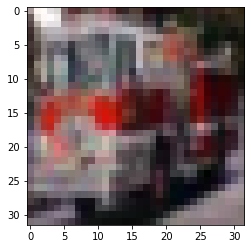

predicted truck
true truck
****************************************************************************************************


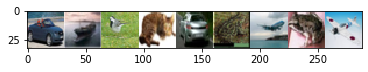

tensor([8.2653e-05, 9.3733e-01, 1.9346e-04, 3.5559e-02, 1.0673e-02, 1.1338e-02,
        3.4393e-04, 4.4646e-03, 1.1322e-05], device='cuda:0',
       dtype=torch.float64)


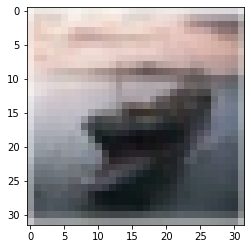

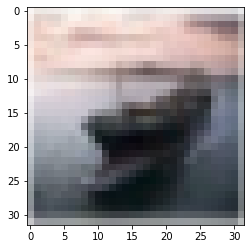

predicted ship
true ship
****************************************************************************************************


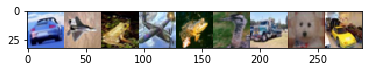

tensor([2.4562e-05, 1.3368e-04, 5.8877e-12, 4.1573e-09, 6.8733e-10, 1.4231e-06,
        9.9983e-01, 1.3632e-05, 7.2678e-07], device='cuda:0',
       dtype=torch.float64)


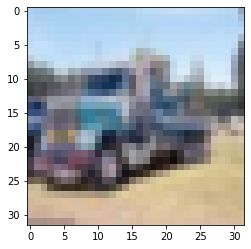

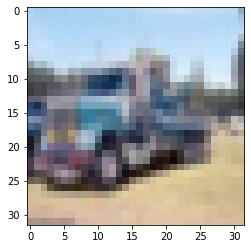

predicted truck
true truck
****************************************************************************************************


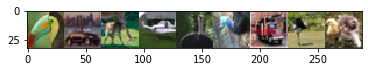

tensor([4.4809e-07, 3.3853e-03, 1.6216e-02, 3.0394e-03, 7.1998e-05, 6.5843e-04,
        9.7516e-01, 1.4726e-03, 5.6629e-08], device='cuda:0',
       dtype=torch.float64)


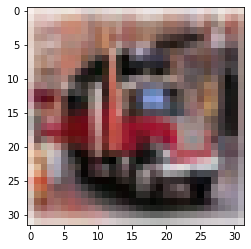

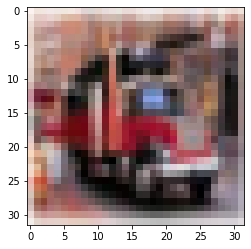

predicted truck
true truck
****************************************************************************************************


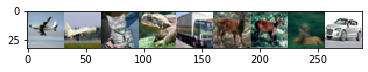

tensor([6.3096e-11, 1.1266e-09, 4.7350e-06, 1.8108e-07, 9.9996e-01, 6.6756e-06,
        2.6887e-05, 1.0575e-06, 1.1227e-06], device='cuda:0',
       dtype=torch.float64)


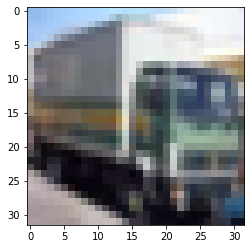

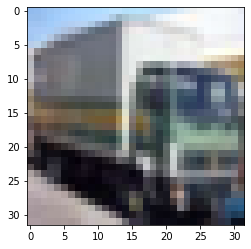

predicted truck
true truck
****************************************************************************************************


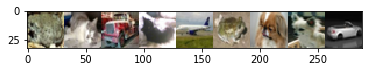

tensor([1.5140e-02, 1.4172e-06, 9.5651e-01, 1.7413e-03, 9.9873e-03, 1.4319e-03,
        3.2300e-04, 1.4860e-02, 3.0657e-06], device='cuda:0',
       dtype=torch.float64)


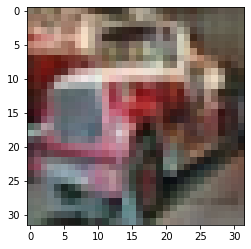

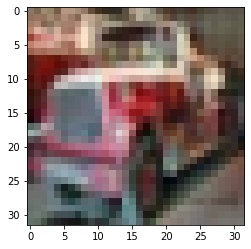

predicted truck
true truck
****************************************************************************************************


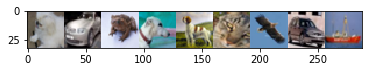

tensor([2.9880e-09, 8.7651e-05, 1.8516e-11, 1.2928e-04, 2.3927e-05, 6.5336e-06,
        4.2992e-09, 1.3839e-05, 9.9974e-01], device='cuda:0',
       dtype=torch.float64)


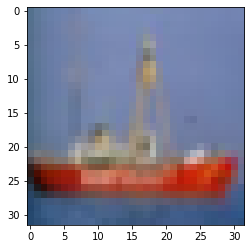

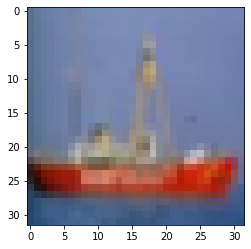

predicted ship
true ship
****************************************************************************************************


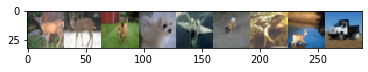

tensor([4.6551e-08, 3.1984e-07, 2.0053e-05, 1.8241e-06, 1.1346e-04, 6.3265e-07,
        6.7208e-06, 3.7602e-07, 9.9986e-01], device='cuda:0',
       dtype=torch.float64)


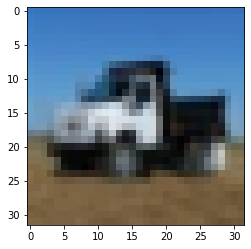

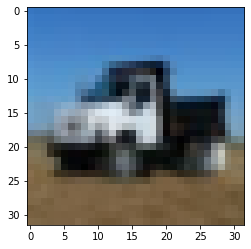

predicted truck
true truck
****************************************************************************************************


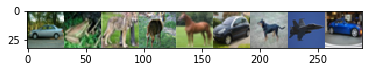

tensor([2.2975e-06, 5.3392e-09, 4.7747e-07, 8.4537e-08, 9.9972e-01, 2.6216e-04,
        1.6309e-07, 2.9137e-09, 1.1335e-05], device='cuda:0',
       dtype=torch.float64)


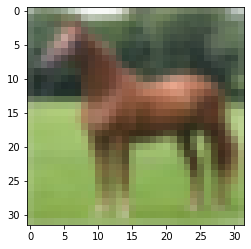

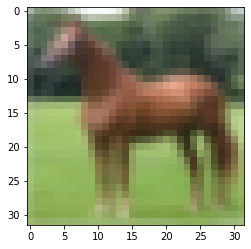

predicted horse
true horse
****************************************************************************************************


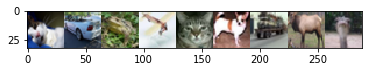

tensor([1.7233e-03, 1.0483e-05, 2.2795e-04, 1.8682e-08, 6.0570e-05, 3.1527e-02,
        9.6426e-01, 2.1920e-03, 6.1083e-07], device='cuda:0',
       dtype=torch.float64)


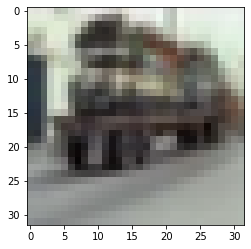

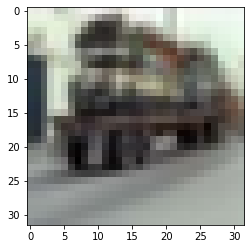

predicted truck
true truck
****************************************************************************************************


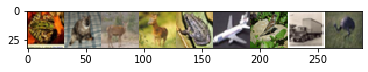

tensor([9.8175e-06, 2.1309e-03, 6.3040e-05, 2.8324e-10, 5.3112e-05, 2.6194e-07,
        2.0531e-11, 9.9768e-01, 6.3766e-05], device='cuda:0',
       dtype=torch.float64)


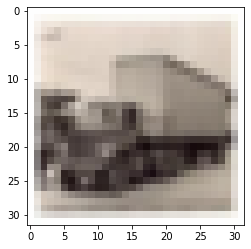

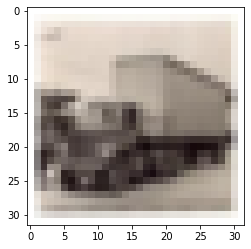

predicted truck
true truck
****************************************************************************************************


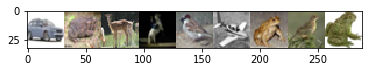

tensor([1.7738e-04, 5.7202e-05, 8.1025e-04, 9.9731e-01, 1.5317e-03, 2.1032e-06,
        2.6931e-05, 7.7749e-05, 4.6530e-06], device='cuda:0',
       dtype=torch.float64)


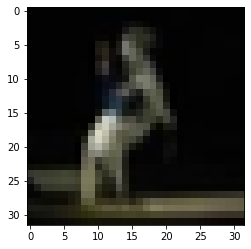

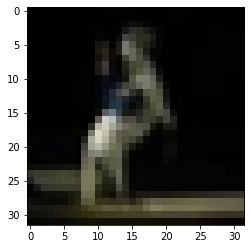

predicted horse
true horse
****************************************************************************************************


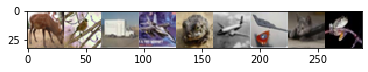

tensor([1.4981e-03, 5.9276e-06, 2.5082e-01, 1.0792e-01, 1.1886e-02, 5.9982e-06,
        1.3064e-03, 8.0788e-02, 5.4577e-01], device='cuda:0',
       dtype=torch.float64)


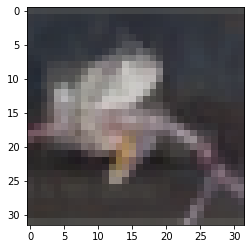

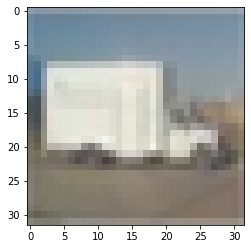

predicted truck
true truck
****************************************************************************************************


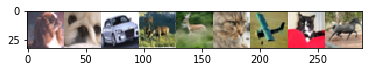

tensor([6.4475e-05, 1.0287e-04, 1.4346e-07, 4.1767e-06, 3.4253e-06, 3.2953e-05,
        9.7955e-07, 6.9782e-08, 9.9979e-01], device='cuda:0',
       dtype=torch.float64)


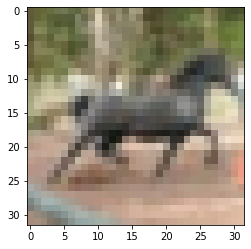

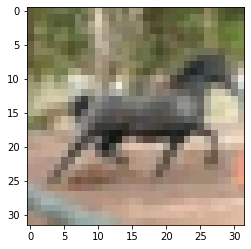

predicted horse
true horse
****************************************************************************************************


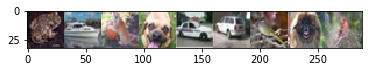

tensor([1.6026e-05, 9.6493e-01, 1.3336e-02, 1.4904e-04, 2.4905e-04, 1.1528e-03,
        1.0103e-02, 9.9143e-03, 1.4793e-04], device='cuda:0',
       dtype=torch.float64)


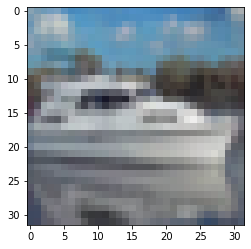

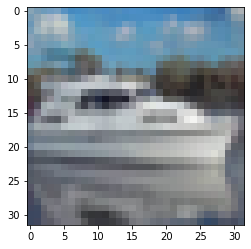

predicted ship
true ship
****************************************************************************************************


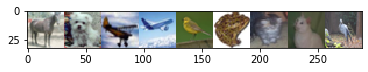

tensor([9.9815e-01, 1.1061e-06, 8.7985e-07, 1.5125e-08, 2.6139e-05, 1.2186e-08,
        3.6092e-06, 4.6173e-06, 1.8104e-03], device='cuda:0',
       dtype=torch.float64)


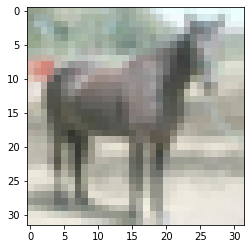

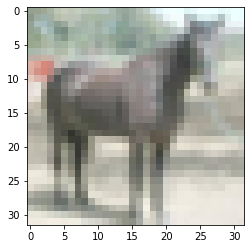

predicted horse
true horse
****************************************************************************************************


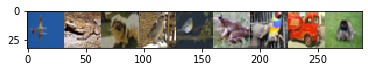

tensor([1.3366e-02, 4.2084e-08, 1.4085e-03, 6.9122e-02, 1.2625e-02, 1.5742e-01,
        2.2823e-02, 7.2320e-01, 3.6129e-05], device='cuda:0',
       dtype=torch.float64)


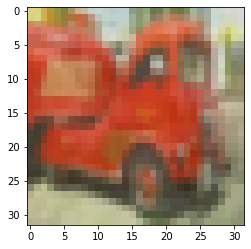

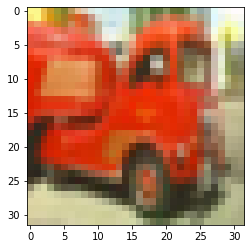

predicted truck
true truck
****************************************************************************************************


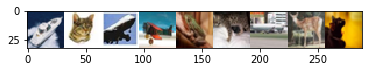

tensor([9.9996e-01, 9.9384e-13, 5.6294e-07, 2.4014e-07, 7.2412e-09, 5.6557e-07,
        4.2578e-05, 1.6374e-08, 2.4942e-09], device='cuda:0',
       dtype=torch.float64)


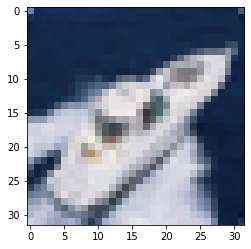

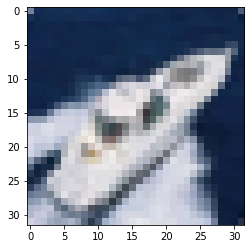

predicted ship
true ship
Accuracy of the network on the 30000 train images: 97 %
total correct 29131
total train set images 30000
focus_true_pred_true 41
focus_false_pred_true 8
focus_true_pred_false 0
focus_false_pred_false 1
argmax_more_than_half 48
argmax_less_than_half 2


In [71]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    if flag==1 :
      for j in range (50):
        print("*"*100)
        img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
        display(img1.cpu())

        print(alphas[j])

        img2 = avg_images[j]
        display(img2.cpu())

        img3 = inputs[j][fore_idx[j]]
        display(img3.cpu())

        print("predicted", classes[predicted[j]+7])
        print("true", classes[labels[j]+7])
        
        focus = torch.argmax(alphas[j])
      
        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1

      flag =0

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
    bg_idx = np.random.randint(0,35000,8)
    fg_idx = np.random.randint(0,15000)
    fg = np.random.randint(0,9)
    fore_idx_test.append(fg)
    image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
    test_images.append(image_list)
    test_label.append(label)

In [0]:
# test_data = MosaicDataset(test_images,test_label,)
# test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

0


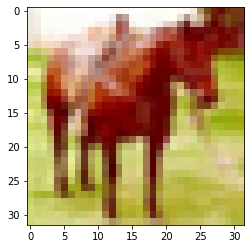

horse


In [74]:
print(fore_idx_test[0])
imshow(test_images[0][fore_idx_test[0]])
print(classes[test_label[0]+7])

****************************************************************************************************


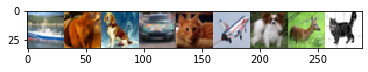

tensor([9.9949e-01, 2.6497e-05, 6.3411e-08, 8.9987e-07, 2.7222e-07, 1.2011e-07,
        4.5619e-04, 6.7857e-06, 1.5603e-05], device='cuda:0',
       dtype=torch.float64)


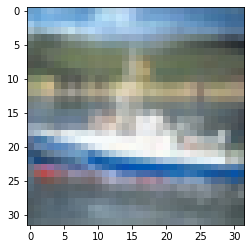

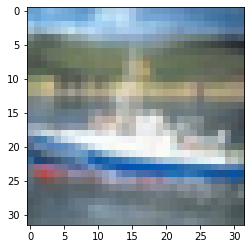

predicted ship
true ship
****************************************************************************************************


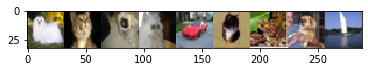

tensor([2.6181e-11, 3.3002e-13, 2.4482e-06, 3.4389e-04, 2.9674e-08, 2.0582e-07,
        1.2076e-06, 4.0082e-10, 9.9965e-01], device='cuda:0',
       dtype=torch.float64)


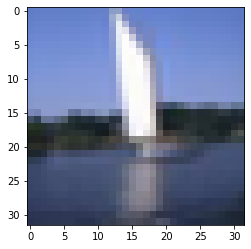

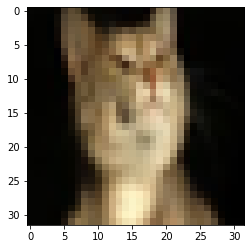

predicted ship
true ship
****************************************************************************************************


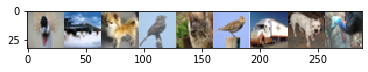

tensor([9.1007e-06, 4.3973e-02, 1.9012e-01, 1.1991e-05, 8.1448e-03, 8.4165e-11,
        7.0420e-01, 3.4470e-02, 1.9073e-02], device='cuda:0',
       dtype=torch.float64)


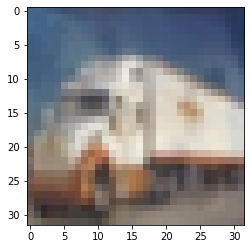

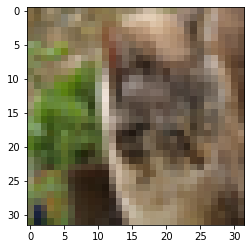

predicted truck
true truck
****************************************************************************************************


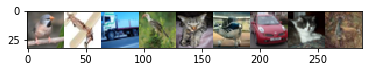

tensor([3.8936e-04, 3.5597e-10, 9.9960e-01, 6.1227e-08, 2.0898e-06, 4.4286e-06,
        2.4130e-06, 3.5565e-10, 3.4497e-06], device='cuda:0',
       dtype=torch.float64)


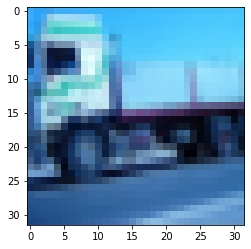

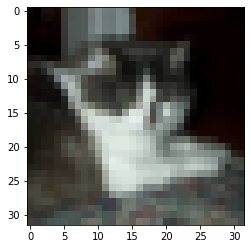

predicted truck
true truck
****************************************************************************************************


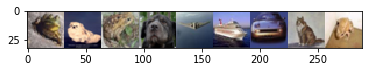

tensor([1.0182e-05, 5.4491e-05, 4.8131e-05, 1.3027e-01, 5.8304e-03, 8.1803e-01,
        1.6531e-03, 4.4102e-02, 2.6705e-07], device='cuda:0',
       dtype=torch.float64)


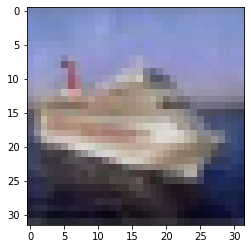

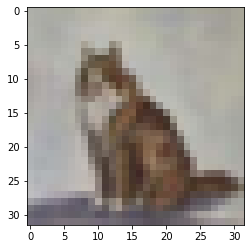

predicted ship
true ship
****************************************************************************************************


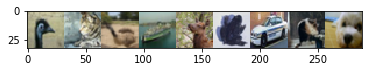

tensor([4.2356e-04, 1.1660e-08, 2.6699e-05, 9.9792e-01, 4.9201e-06, 5.6933e-08,
        2.9768e-04, 1.3126e-03, 1.0124e-05], device='cuda:0',
       dtype=torch.float64)


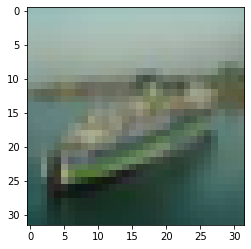

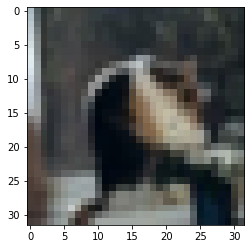

predicted ship
true ship
****************************************************************************************************


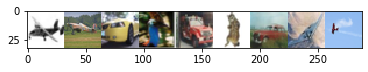

tensor([2.1831e-07, 1.3853e-03, 1.6120e-02, 4.4080e-01, 5.3025e-01, 1.4636e-05,
        1.2370e-03, 1.0186e-02, 5.2955e-08], device='cuda:0',
       dtype=torch.float64)


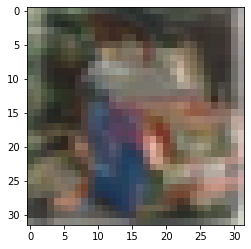

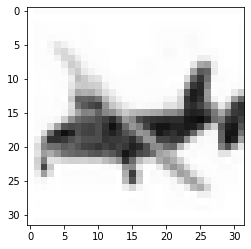

predicted truck
true truck
****************************************************************************************************


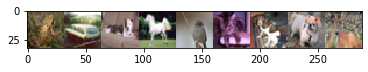

tensor([1.1165e-08, 6.0176e-06, 1.0342e-07, 9.9999e-01, 1.8238e-06, 3.1920e-13,
        1.3192e-07, 8.7436e-08, 6.5808e-07], device='cuda:0',
       dtype=torch.float64)


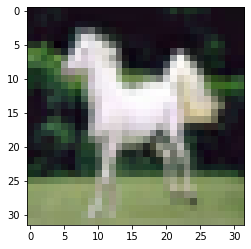

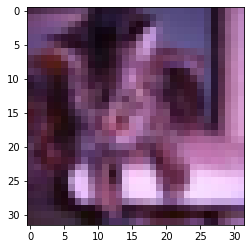

predicted horse
true horse
****************************************************************************************************


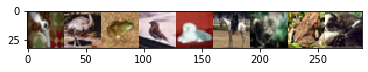

tensor([8.5783e-10, 1.3924e-06, 4.3910e-08, 3.8372e-07, 6.5499e-07, 9.9998e-01,
        8.3495e-06, 6.4844e-07, 7.8574e-06], device='cuda:0',
       dtype=torch.float64)


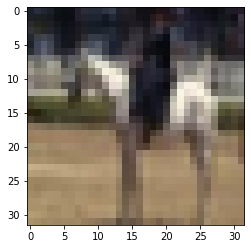

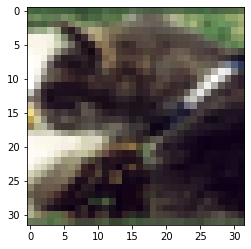

predicted horse
true horse
****************************************************************************************************


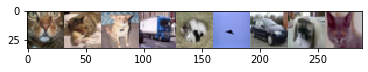

tensor([1.6130e-05, 3.9189e-06, 2.0134e-06, 1.9391e-01, 7.4276e-05, 4.0957e-07,
        5.4890e-01, 2.2951e-01, 2.7581e-02], device='cuda:0',
       dtype=torch.float64)


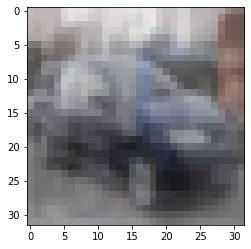

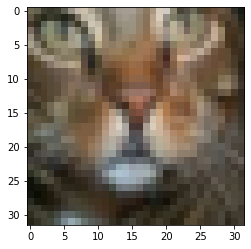

predicted truck
true truck
****************************************************************************************************


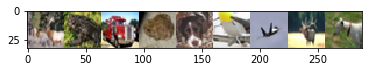

tensor([2.3835e-05, 9.7533e-05, 9.8709e-01, 2.7555e-07, 9.5370e-05, 1.2586e-02,
        2.6558e-07, 3.5974e-10, 1.1107e-04], device='cuda:0',
       dtype=torch.float64)


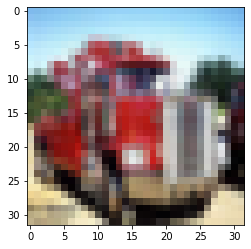

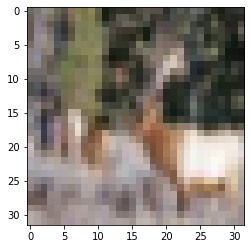

predicted truck
true truck
****************************************************************************************************


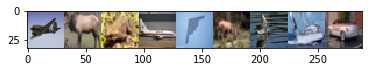

tensor([7.6006e-12, 6.0658e-06, 3.8266e-08, 2.5438e-07, 1.6738e-08, 3.8034e-04,
        2.3516e-07, 9.9961e-01, 8.8219e-08], device='cuda:0',
       dtype=torch.float64)


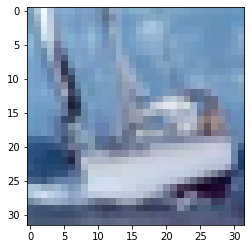

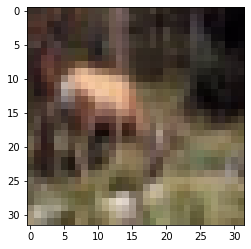

predicted ship
true ship
****************************************************************************************************


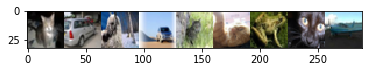

tensor([2.0393e-04, 4.0263e-04, 9.9313e-01, 9.3029e-06, 2.8159e-04, 8.0005e-04,
        7.1234e-07, 1.0912e-03, 4.0791e-03], device='cuda:0',
       dtype=torch.float64)


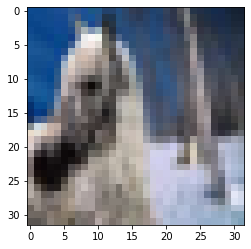

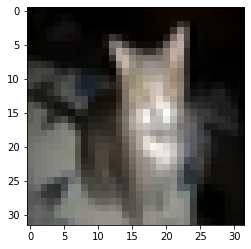

predicted horse
true horse
****************************************************************************************************


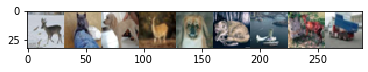

tensor([6.2688e-04, 7.4714e-06, 1.0639e-05, 6.4422e-05, 5.8249e-05, 3.0125e-06,
        9.8596e-01, 9.4922e-03, 3.7809e-03], device='cuda:0',
       dtype=torch.float64)


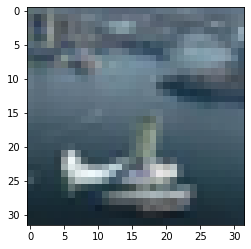

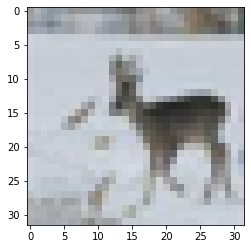

predicted ship
true truck
****************************************************************************************************


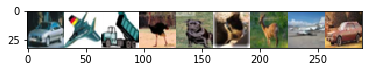

tensor([2.0053e-02, 4.2299e-06, 4.3781e-01, 3.4396e-06, 4.0314e-01, 1.3538e-01,
        4.4487e-05, 6.2021e-04, 2.9361e-03], device='cuda:0',
       dtype=torch.float64)


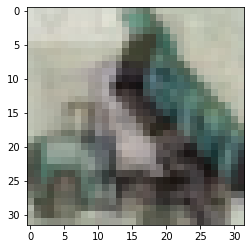

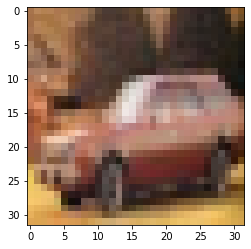

predicted truck
true truck
****************************************************************************************************


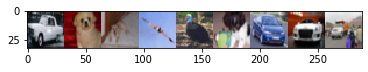

tensor([2.9543e-03, 1.1885e-08, 3.2110e-04, 6.0540e-06, 5.4522e-03, 4.4814e-11,
        1.1363e-03, 3.6348e-04, 9.8977e-01], device='cuda:0',
       dtype=torch.float64)


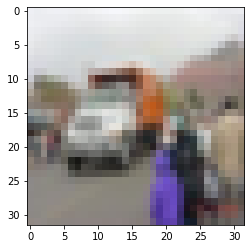

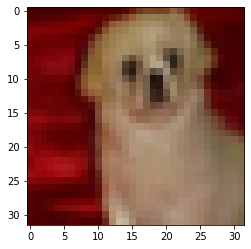

predicted truck
true truck
****************************************************************************************************


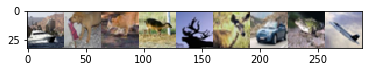

tensor([2.5224e-05, 9.6263e-01, 1.4716e-03, 2.4106e-04, 5.9752e-03, 3.8207e-06,
        2.8513e-02, 1.6523e-04, 9.7720e-04], device='cuda:0',
       dtype=torch.float64)


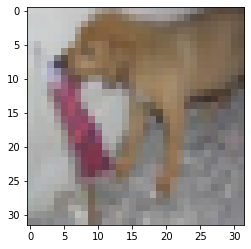

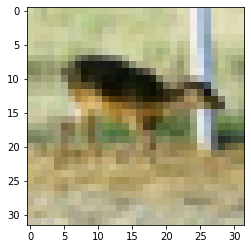

predicted horse
true ship
****************************************************************************************************


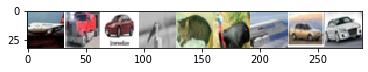

tensor([4.8865e-05, 4.8391e-02, 3.8060e-04, 5.7789e-04, 5.2689e-03, 3.1064e-05,
        9.1138e-01, 3.3893e-02, 2.6496e-05], device='cuda:0',
       dtype=torch.float64)


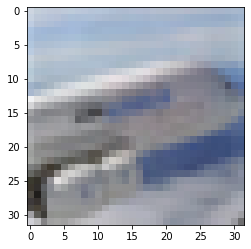

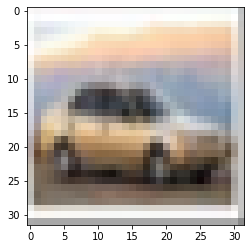

predicted ship
true truck
****************************************************************************************************


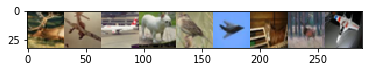

tensor([3.5909e-04, 3.3717e-05, 4.0737e-04, 1.1717e-03, 5.3708e-03, 2.3568e-10,
        4.4090e-01, 5.5171e-01, 5.4696e-05], device='cuda:0',
       dtype=torch.float64)


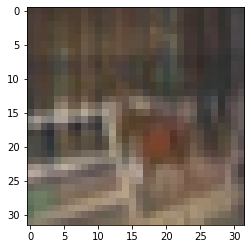

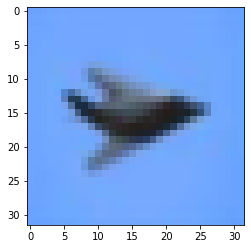

predicted horse
true horse
****************************************************************************************************


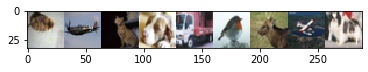

tensor([1.4370e-09, 3.2953e-04, 6.0184e-04, 1.0253e-06, 7.7423e-01, 2.2297e-01,
        1.4642e-04, 1.7209e-03, 8.7583e-09], device='cuda:0',
       dtype=torch.float64)


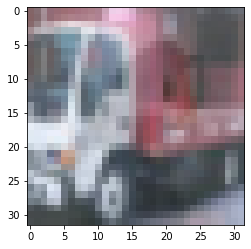

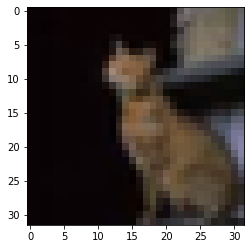

predicted truck
true truck
****************************************************************************************************


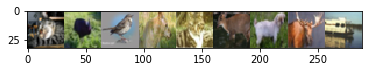

tensor([6.9635e-04, 1.7387e-05, 1.1724e-03, 1.0931e-03, 4.0000e-06, 1.2476e-01,
        1.7549e-02, 4.1093e-03, 8.5060e-01], device='cuda:0',
       dtype=torch.float64)


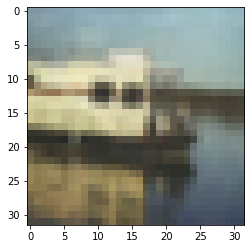

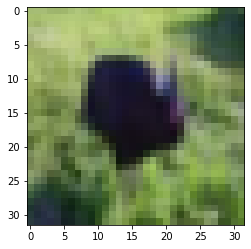

predicted ship
true ship
****************************************************************************************************


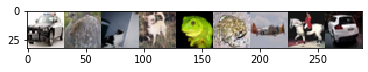

tensor([6.5324e-09, 3.7086e-06, 4.3421e-08, 5.0723e-09, 3.1725e-17, 2.3664e-09,
        8.9264e-11, 1.0000e+00, 1.0074e-06], device='cuda:0',
       dtype=torch.float64)


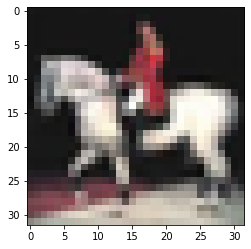

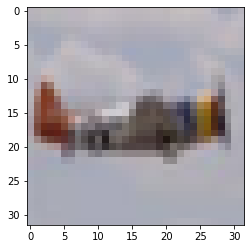

predicted horse
true horse
****************************************************************************************************


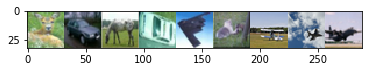

tensor([2.8963e-08, 7.0750e-04, 9.9922e-01, 1.3021e-07, 2.2800e-14, 1.7346e-05,
        1.3268e-08, 5.8356e-05, 3.5301e-07], device='cuda:0',
       dtype=torch.float64)


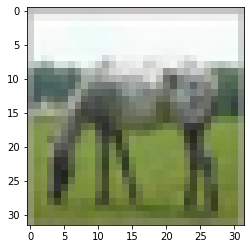

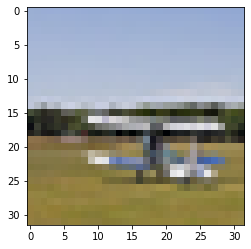

predicted horse
true horse
****************************************************************************************************


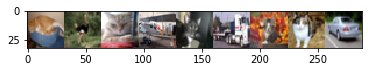

tensor([2.2867e-05, 7.2876e-05, 3.0276e-05, 3.9605e-05, 4.1822e-07, 9.9854e-01,
        8.4144e-07, 4.1513e-07, 1.2915e-03], device='cuda:0',
       dtype=torch.float64)


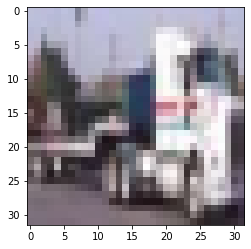

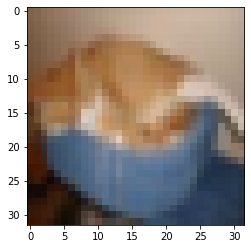

predicted horse
true truck
****************************************************************************************************


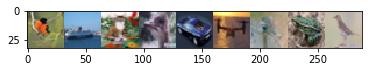

tensor([8.9061e-06, 9.9861e-01, 6.4913e-05, 5.6693e-06, 1.1755e-04, 1.5696e-05,
        1.1025e-03, 6.7451e-05, 3.4569e-06], device='cuda:0',
       dtype=torch.float64)


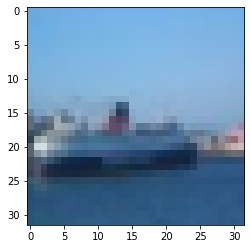

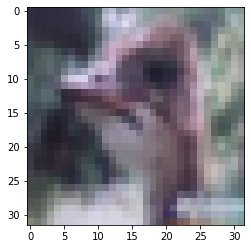

predicted ship
true ship
****************************************************************************************************


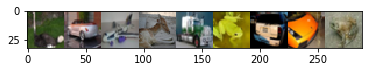

tensor([3.9894e-03, 7.4783e-05, 3.2326e-04, 6.8122e-03, 9.8874e-01, 1.4227e-07,
        2.1385e-05, 8.3157e-07, 3.5244e-05], device='cuda:0',
       dtype=torch.float64)


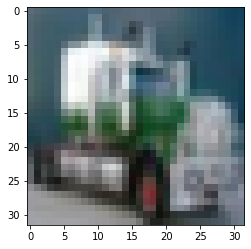

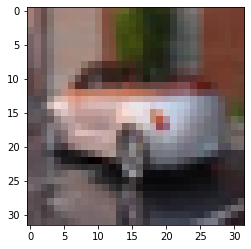

predicted truck
true truck
****************************************************************************************************


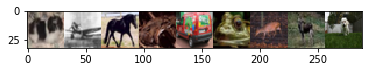

tensor([8.0879e-07, 2.5107e-08, 9.9998e-01, 2.8122e-07, 1.6414e-05, 6.0654e-07,
        4.0641e-07, 1.0109e-08, 2.5830e-08], device='cuda:0',
       dtype=torch.float64)


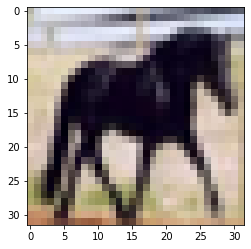

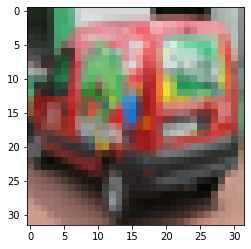

predicted horse
true horse
****************************************************************************************************


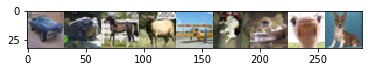

tensor([1.1695e-06, 1.6238e-06, 9.9998e-01, 4.8714e-07, 9.8738e-06, 6.0374e-08,
        1.5782e-06, 3.7052e-06, 6.8513e-08], device='cuda:0',
       dtype=torch.float64)


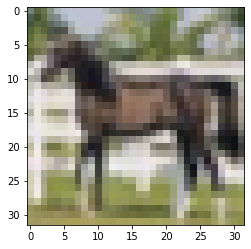

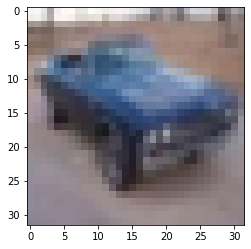

predicted horse
true horse
****************************************************************************************************


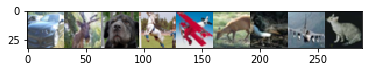

tensor([5.7721e-02, 7.2421e-04, 5.3370e-02, 7.9284e-01, 5.9758e-03, 2.2726e-03,
        5.9636e-06, 8.6121e-02, 9.6556e-04], device='cuda:0',
       dtype=torch.float64)


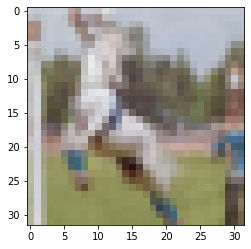

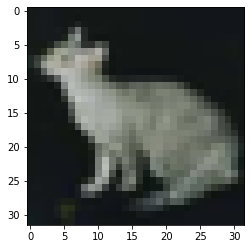

predicted horse
true horse
****************************************************************************************************


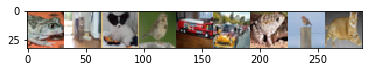

tensor([1.0751e-03, 3.7159e-03, 2.2309e-02, 1.8181e-03, 9.7076e-01, 1.8899e-06,
        1.6917e-04, 3.6698e-05, 1.1621e-04], device='cuda:0',
       dtype=torch.float64)


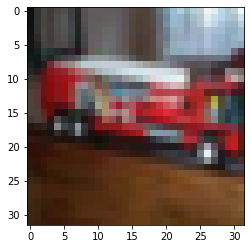

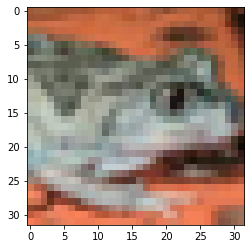

predicted truck
true truck
****************************************************************************************************


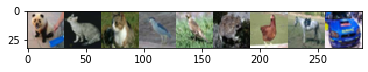

tensor([4.5794e-02, 1.3423e-01, 1.2171e-03, 6.3045e-01, 5.4347e-04, 1.0252e-01,
        1.1534e-02, 6.7938e-02, 5.7746e-03], device='cuda:0',
       dtype=torch.float64)


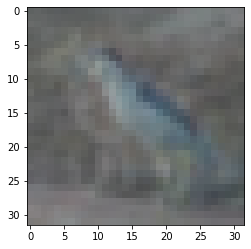

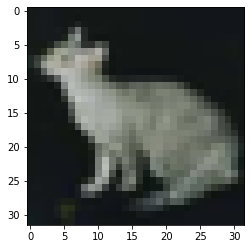

predicted truck
true horse
****************************************************************************************************


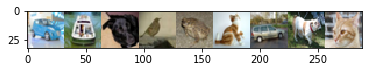

tensor([1.0138e-05, 9.4698e-01, 3.0745e-03, 2.0148e-05, 5.9501e-04, 4.0075e-05,
        3.5942e-04, 4.8251e-02, 6.6613e-04], device='cuda:0',
       dtype=torch.float64)


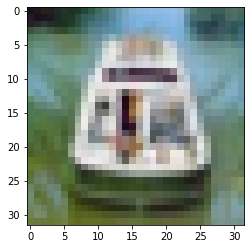

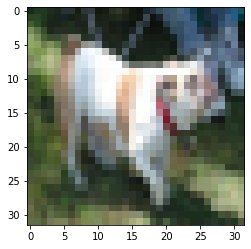

predicted ship
true ship
****************************************************************************************************


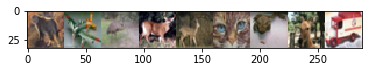

tensor([2.4695e-03, 1.2498e-05, 1.1814e-04, 3.3684e-04, 5.6595e-06, 9.8881e-04,
        1.1181e-12, 1.9456e-03, 9.9412e-01], device='cuda:0',
       dtype=torch.float64)


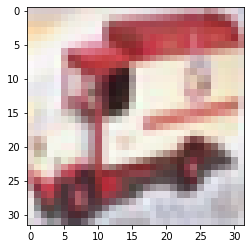

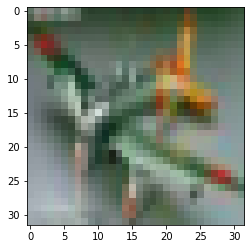

predicted truck
true truck
****************************************************************************************************


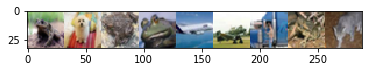

tensor([6.3824e-03, 7.5508e-02, 4.3775e-05, 1.5758e-03, 2.4305e-04, 5.2237e-03,
        9.1073e-01, 1.1174e-05, 2.8589e-04], device='cuda:0',
       dtype=torch.float64)


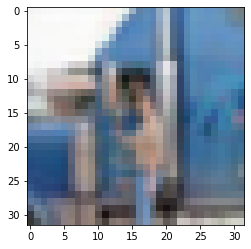

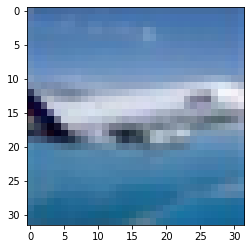

predicted ship
true truck
****************************************************************************************************


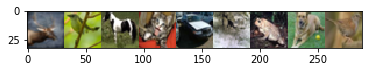

tensor([4.3731e-08, 4.1257e-08, 9.9999e-01, 2.5530e-07, 4.0029e-07, 6.0690e-10,
        6.0534e-06, 1.5364e-06, 2.2311e-10], device='cuda:0',
       dtype=torch.float64)


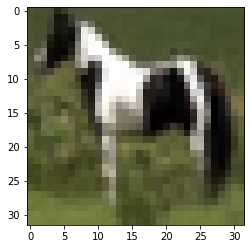

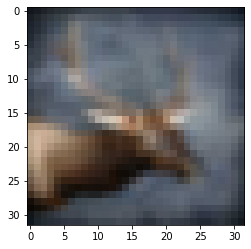

predicted horse
true horse
****************************************************************************************************


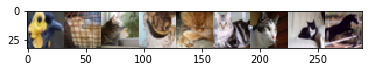

tensor([4.3386e-06, 5.0110e-03, 6.5118e-06, 3.3188e-04, 1.1051e-05, 2.3266e-03,
        1.5371e-05, 1.1825e-04, 9.9217e-01], device='cuda:0',
       dtype=torch.float64)


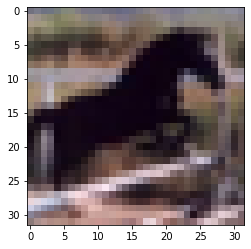

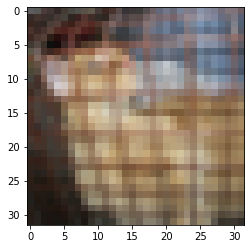

predicted horse
true horse
****************************************************************************************************


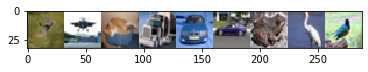

tensor([8.9185e-06, 1.4568e-02, 2.9000e-01, 1.5558e-02, 6.1728e-03, 6.5247e-01,
        1.9943e-02, 1.2788e-03, 2.8069e-06], device='cuda:0',
       dtype=torch.float64)


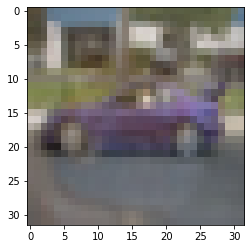

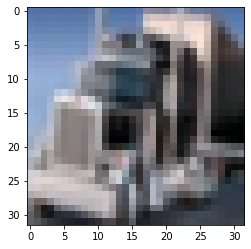

predicted truck
true truck
****************************************************************************************************


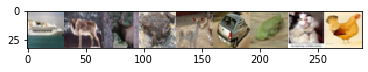

tensor([9.9415e-01, 9.1495e-06, 5.1161e-03, 6.7782e-06, 2.5763e-06, 3.5659e-05,
        3.0523e-06, 6.7438e-04, 1.0624e-08], device='cuda:0',
       dtype=torch.float64)


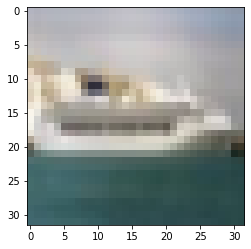

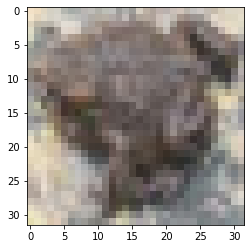

predicted ship
true ship
****************************************************************************************************


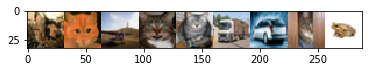

tensor([5.9677e-02, 3.1646e-07, 4.2319e-03, 2.5699e-03, 2.3432e-01, 6.8725e-01,
        9.9817e-03, 1.9755e-03, 1.9611e-06], device='cuda:0',
       dtype=torch.float64)


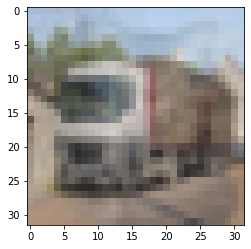

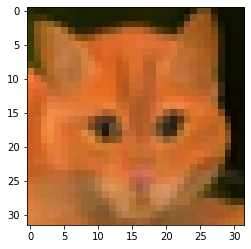

predicted truck
true truck
****************************************************************************************************


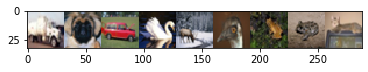

tensor([9.9963e-01, 8.1897e-09, 1.0323e-07, 4.8687e-05, 2.0606e-04, 6.2114e-08,
        3.5698e-05, 1.3632e-06, 7.6656e-05], device='cuda:0',
       dtype=torch.float64)


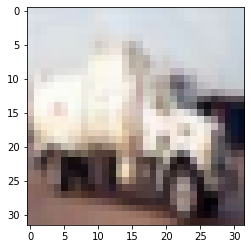

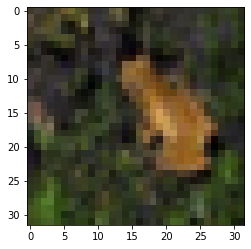

predicted truck
true truck
****************************************************************************************************


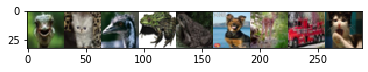

tensor([1.9314e-01, 5.2412e-08, 6.1461e-01, 2.7190e-05, 1.9921e-02, 6.7042e-04,
        4.5882e-02, 1.2433e-01, 1.4293e-03], device='cuda:0',
       dtype=torch.float64)


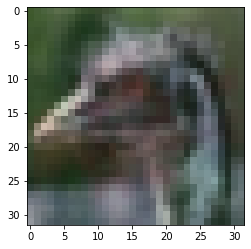

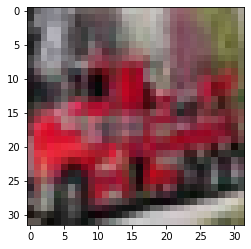

predicted horse
true truck
****************************************************************************************************


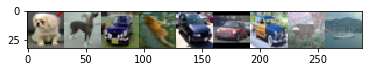

tensor([2.1546e-09, 1.8655e-04, 1.2602e-02, 5.8092e-10, 1.5184e-04, 1.0773e-06,
        1.2548e-03, 4.8753e-05, 9.8575e-01], device='cuda:0',
       dtype=torch.float64)


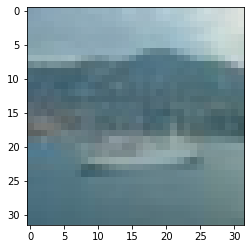

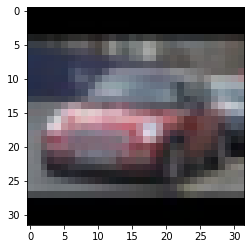

predicted ship
true ship
****************************************************************************************************


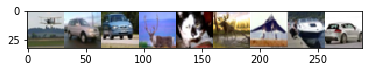

tensor([5.0009e-03, 1.7268e-04, 1.9813e-03, 4.7989e-05, 5.2028e-04, 4.7701e-04,
        1.4513e-05, 9.9160e-01, 1.8415e-04], device='cuda:0',
       dtype=torch.float64)


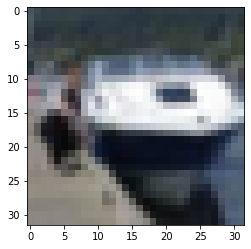

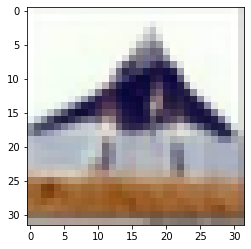

predicted ship
true ship
****************************************************************************************************


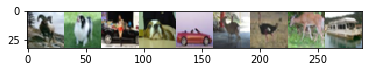

tensor([1.5317e-01, 2.5319e-07, 1.0742e-02, 4.0348e-05, 1.3240e-02, 1.4023e-05,
        5.7187e-08, 8.3887e-05, 8.2271e-01], device='cuda:0',
       dtype=torch.float64)


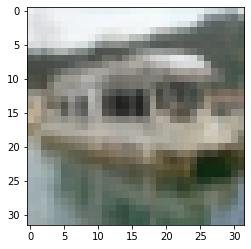

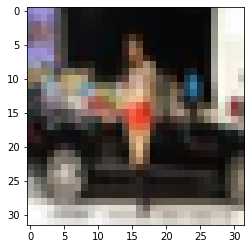

predicted ship
true ship
****************************************************************************************************


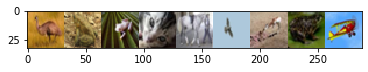

tensor([2.1316e-08, 1.3670e-04, 9.7904e-01, 2.3207e-03, 3.3107e-07, 1.1145e-08,
        1.2311e-02, 3.2718e-04, 5.8684e-03], device='cuda:0',
       dtype=torch.float64)


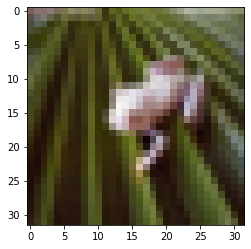

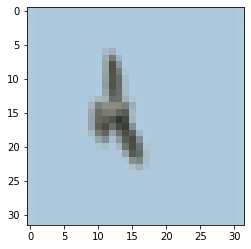

predicted horse
true horse
****************************************************************************************************


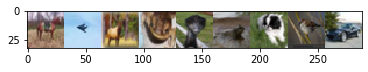

tensor([9.9996e-01, 1.2628e-09, 1.6637e-07, 4.3220e-06, 2.6765e-06, 1.5781e-05,
        6.2430e-12, 7.4220e-06, 1.2596e-05], device='cuda:0',
       dtype=torch.float64)


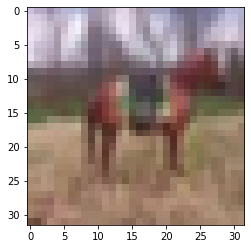

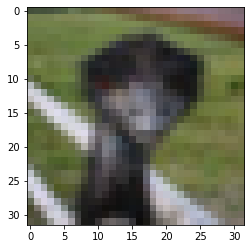

predicted horse
true horse
****************************************************************************************************


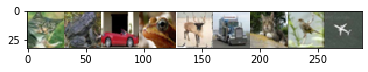

tensor([6.8957e-05, 3.6539e-04, 5.4560e-07, 1.0818e-04, 3.5490e-05, 9.8444e-01,
        9.7134e-03, 5.0253e-03, 2.4721e-04], device='cuda:0',
       dtype=torch.float64)


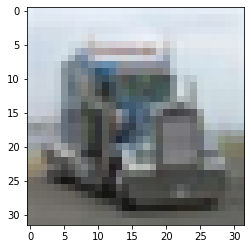

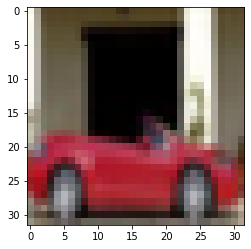

predicted truck
true truck
****************************************************************************************************


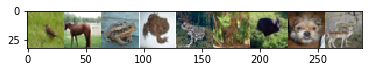

tensor([1.2805e-14, 1.0000e+00, 1.2653e-08, 2.9003e-17, 7.1345e-09, 1.1525e-08,
        1.1136e-13, 1.0948e-11, 6.3305e-09], device='cuda:0',
       dtype=torch.float64)


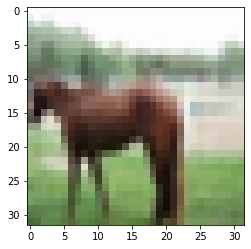

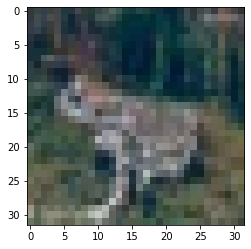

predicted horse
true horse
****************************************************************************************************


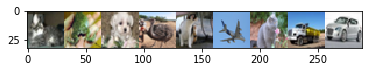

tensor([8.5122e-04, 2.6542e-04, 2.9639e-04, 5.3964e-01, 2.1136e-03, 1.4902e-05,
        6.7790e-05, 4.5668e-01, 7.0379e-05], device='cuda:0',
       dtype=torch.float64)


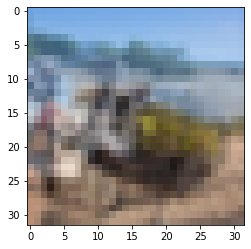

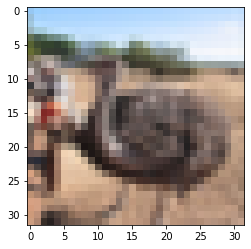

predicted truck
true truck
****************************************************************************************************


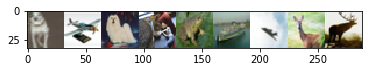

tensor([7.3798e-04, 5.8225e-05, 5.8010e-04, 1.2800e-04, 3.0367e-06, 9.9848e-01,
        3.6189e-09, 1.4308e-05, 4.4415e-07], device='cuda:0',
       dtype=torch.float64)


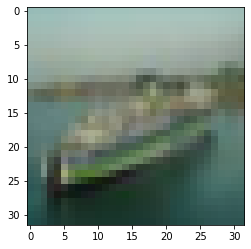

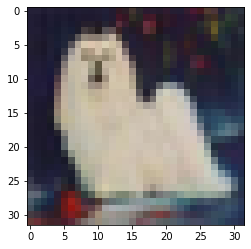

predicted ship
true ship
Accuracy of the network on the 10000 test images: 82 %
total correct 8268
total test set images 10000


In [75]:
correct = 0
total = 0
flag =1
with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)
    _, predicted = torch.max(outputs.data, 1)


    if flag==1 :
      for j in range (50):
        print("*"*100)
        img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
        display(img1.cpu())

        print(alphas[j])

        img2 = avg_images[j]
        display(img2.cpu())

        img3 = inputs[j][fore_idx_test[j]]
        display(img3.cpu())

        print("predicted", classes[predicted[j]+7])
        print("true", classes[labels[j]+7])

      flag =0


    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
print("total correct", correct)
print("total test set images", total)

In [0]:
a = torch.tensor([0.0071, 0.0466, 0.0025, 0.0282, 0.0140, 0.0067, 0.0145, 0.8750, 0.0055])

In [77]:
print(torch.argmax(a) == 7)
print(batch)

tensor(True)
250


In [78]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)
    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 97 %
total correct 29131
total train set images 30000
focus_true_pred_true 24557
focus_false_pred_true 4574
focus_true_pred_false 234
focus_false_pred_false 635
argmax_more_than_half 28990
argmax_less_than_half 1010


In [79]:
bg_idx = np.random.randint(0,35000,8)
fg_idx = np.random.randint(0,15000)
fg = np.random.randint(0,9)
fore_idx_test.append(fg)
image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
test_images.append(image_list)
test_label.append(label)
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)

    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 82 %
total correct 8268
total train set images 10000
focus_true_pred_true 7281
focus_false_pred_true 987
focus_true_pred_false 355
focus_false_pred_false 1377
argmax_more_than_half 9270
argmax_less_than_half 730


In [0]:
# epoch = 100
# for i in range(epoch):
#   if (i %40) <20:
#     print("What",i)
#   elif (i%40)>20:
#     print("Where",i)